In [25]:
# source: https://mathlab.github.io/PyDMD/

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from pydmd import DMD

In [11]:
def f1(x,t): 
    return 1./np.cosh(x+3)*np.exp(2.3j*t)

def f2(x,t):
    return 2./np.cosh(x)*np.tanh(x)*np.exp(2.8j*t)

x = np.linspace(-5, 5, 128)
t = np.linspace(0, 4*np.pi, 256)

xgrid, tgrid = np.meshgrid(x, t)

X1 = f1(xgrid, tgrid)
X2 = f2(xgrid, tgrid)
X = X1 + X2

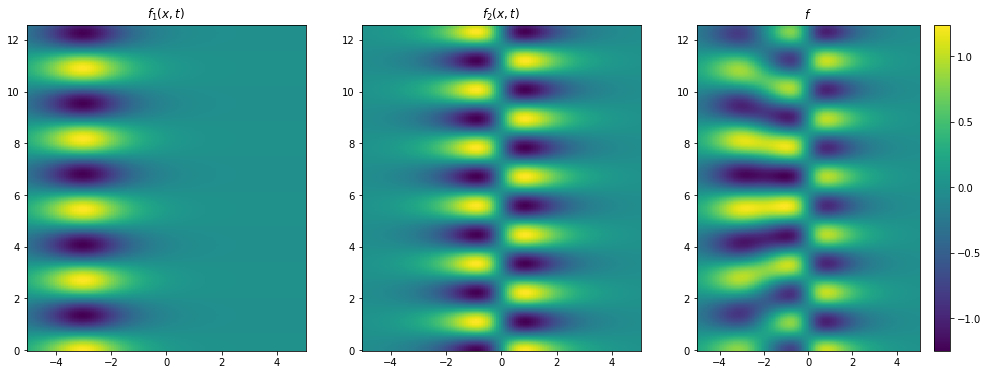

In [12]:
titles = ['$f_1(x,t)$', '$f_2(x,t)$', '$f$']
data = [X1, X2, X]

fig = plt.figure(figsize=(17,6))
for n, title, d in zip(range(131,134), titles, data):
    plt.subplot(n)
    plt.pcolor(xgrid, tgrid, d.real)
    plt.title(title)
plt.colorbar()
plt.show()

In [13]:
dmd = DMD(svd_rank=2)
dmd.fit(X.T)

C:\Users\murat\AppData\Roaming\Python\Python39\site-packages\pydmd\dmdbase.py:348: UserWarning: Input data matrix X has condition number 3.7435702698098975e+18. Consider preprocessing data, passing in augmented data matrix, or regularization methods.
  warnings.warn(


Eigenvalue (0.9904953470777577+0.13754623737970006j): distance from unit circle 4.440892098500626e-16
Eigenvalue (0.993583472609683+0.113101206699502j): distance from unit circle 2.220446049250313e-16


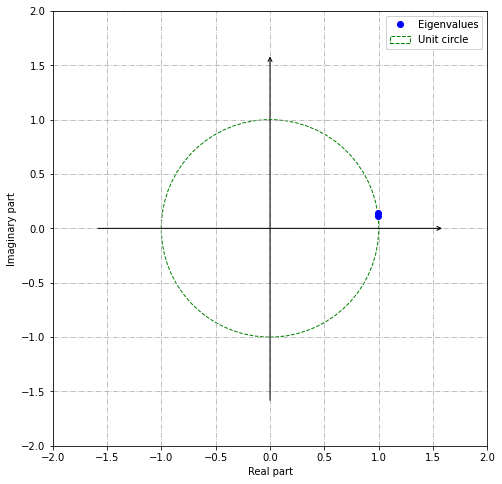

In [14]:
for eig in dmd.eigs:
    print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(eig.imag**2+eig.real**2 - 1)))

dmd.plot_eigs(show_axes=True, show_unit_circle=True)

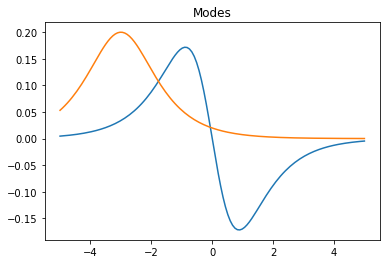

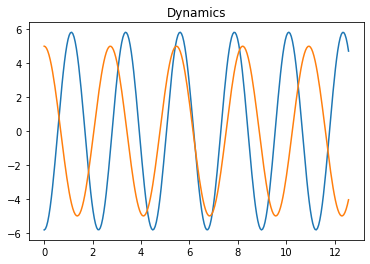

In [15]:
for mode in dmd.modes.T:
    plt.plot(x, mode.real)
    plt.title('Modes')
plt.show()

for dynamic in dmd.dynamics:
    plt.plot(t, dynamic.real)
    plt.title('Dynamics')
plt.show()

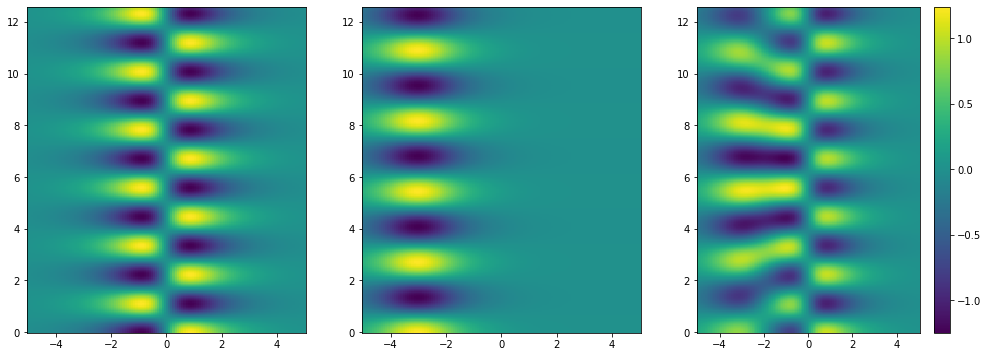

In [16]:
fig = plt.figure(figsize=(17,6))

for n, mode, dynamic in zip(range(131, 133), dmd.modes.T, dmd.dynamics):
    plt.subplot(n)
    plt.pcolor(xgrid, tgrid, (mode.reshape(-1, 1).dot(dynamic.reshape(1, -1))).real.T)
    
plt.subplot(133)
plt.pcolor(xgrid, tgrid, dmd.reconstructed_data.T.real)
plt.colorbar()

plt.show()

# ex 2

In [17]:
%matplotlib inline
import numpy as np
import scipy
import scipy.integrate

from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
from pydmd import DMD

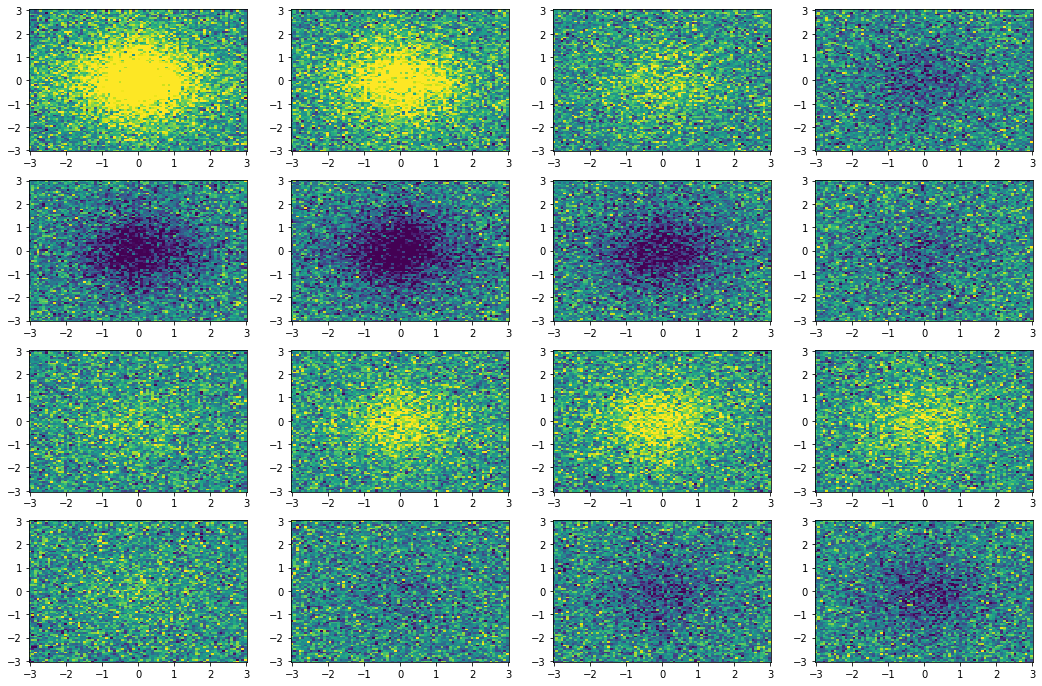

In [18]:
x1 = np.linspace(-3, 3, 80)
x2 = np.linspace(-3, 3, 80)
x1grid, x2grid = np.meshgrid(x1, x2)

time = np.linspace(0, 6, 16)

data = [2/np.cosh(x1grid)/np.cosh(x2grid)*(1.2j**-t) for t in time]
noise = [np.random.normal(0.0, 0.4, size=x1grid.shape) for t in time]

snapshots = [d+n for d,n in zip(data, noise)]

fig = plt.figure(figsize=(18,12))
for id_subplot, snapshot in enumerate(snapshots, start=1):
    plt.subplot(4, 4, id_subplot)
    plt.pcolor(x1grid, x2grid, snapshot.real, vmin=-1, vmax=1)

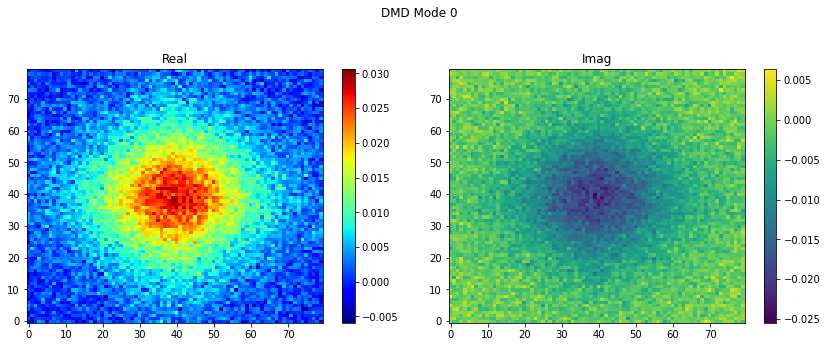

In [19]:
dmd = DMD(svd_rank=1, tlsq_rank=2, exact=True, opt=True)
dmd.fit(snapshots)
dmd.plot_modes_2D(figsize=(12,5))

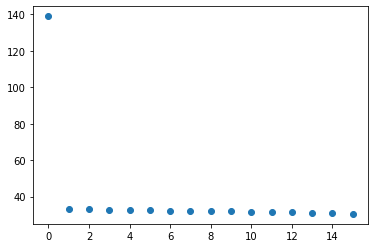

In [20]:
fig = plt.plot(scipy.linalg.svdvals(np.array([snapshot.flatten() for snapshot in snapshots]).T), 'o')

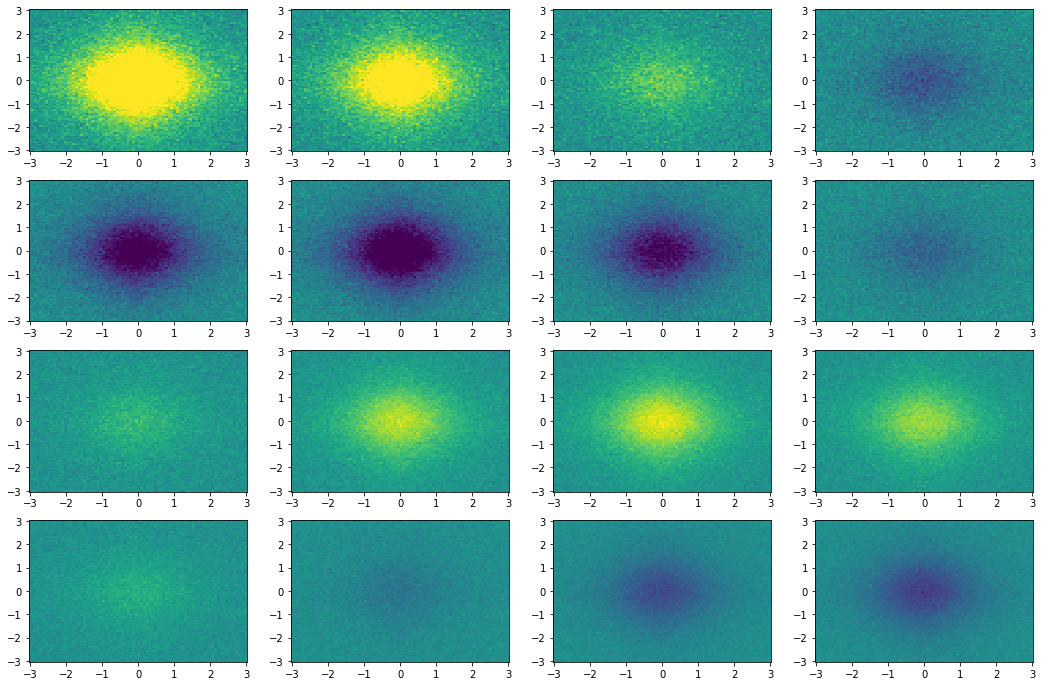

In [21]:
fig = plt.figure(figsize=(18,12))
for id_subplot, snapshot in enumerate(dmd.reconstructed_data.T, start=1):
    plt.subplot(4, 4, id_subplot)
    plt.pcolor(x1grid, x2grid, snapshot.reshape(x1grid.shape).real, vmin=-1, vmax=1)

In [22]:
print("Shape before manipulation: {}".format(dmd.reconstructed_data.shape))
dmd.dmd_time['dt'] *= .25
dmd.dmd_time['tend'] *= 3
print("Shape after manipulation: {}".format(dmd.reconstructed_data.shape))

Shape before manipulation: (6400, 16)
Shape after manipulation: (6400, 181)


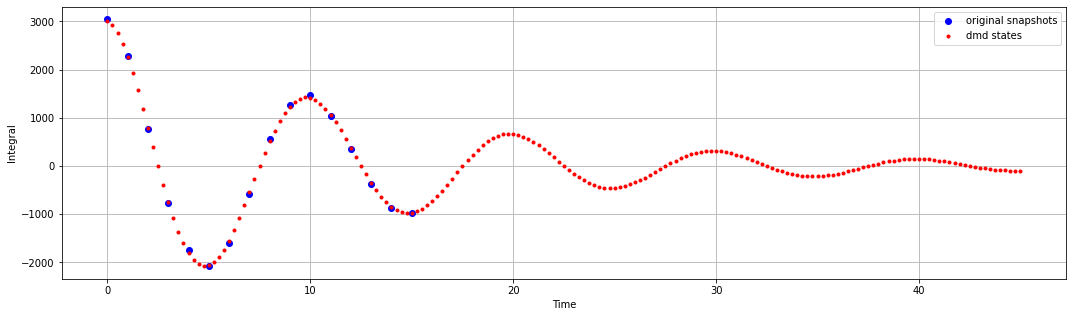

In [24]:
compute_integral = scipy.integrate.trapz

original_int = [compute_integral(compute_integral(snapshot)).real for snapshot in snapshots]
dmd_int = [compute_integral(compute_integral(state)).real for state in dmd_states]

figure = plt.figure(figsize=(18, 5))
plt.plot(dmd.original_timesteps, original_int, 'bo', label='original snapshots')
plt.plot(dmd.dmd_timesteps, dmd_int, 'r.', label='dmd states')
plt.ylabel('Integral')
plt.xlabel('Time')
plt.grid()
leg = plt.legend()

In [26]:
# ex3
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy

from pydmd import DMDc

In [27]:
def create_system(n, m):
    A = scipy.linalg.helmert(n, True)
    B = np.random.rand(n, n)-.5
    x0 = np.array([0.25]*n)
    u = np.random.rand(n, m-1)-.5
    snapshots = [x0]
    for i in range(m-1):
        snapshots.append(A.dot(snapshots[i])+B.dot(u[:, i]))
    snapshots = np.array(snapshots).T
    return {'snapshots': snapshots, 'u': u, 'B': B, 'A': A}

In [28]:
s = create_system(25, 10)
print(s['snapshots'].shape)

(25, 10)


In [29]:
dmdc = DMDc(svd_rank=-1)
dmdc.fit(s['snapshots'], s['u'])

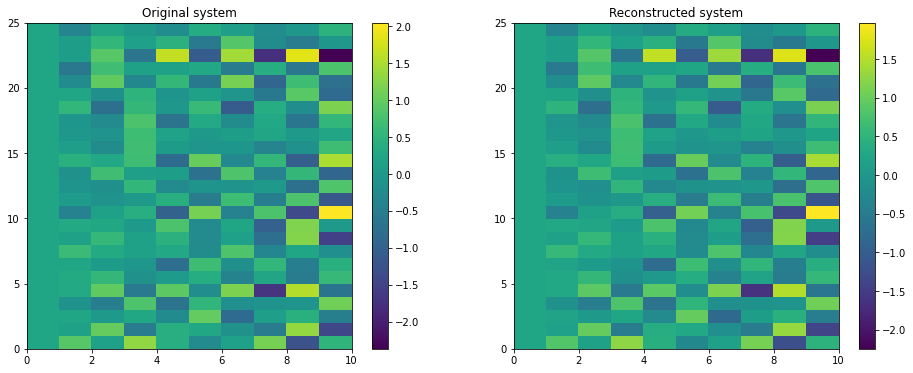

In [30]:
plt.figure(figsize=(16,6))

plt.subplot(121)
plt.title('Original system')
plt.pcolor(s['snapshots'].real)
plt.colorbar()

plt.subplot(122)
plt.title('Reconstructed system')
plt.pcolor(dmdc.reconstructed_data().real)
plt.colorbar()

plt.show()

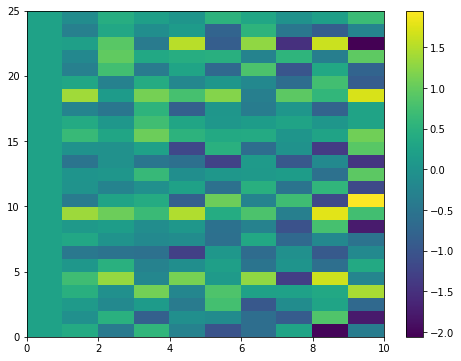

In [31]:
new_u = np.exp(s['u'])

plt.figure(figsize=(8,6))
plt.pcolor(dmdc.reconstructed_data(new_u).real)
plt.colorbar()
plt.show()

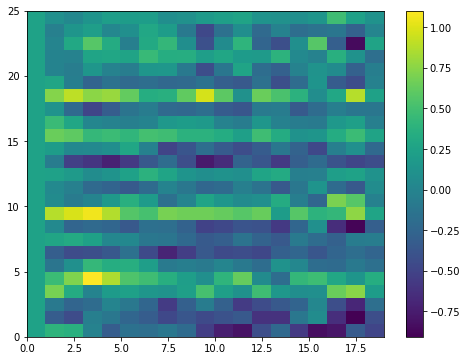

In [32]:
dmdc.dmd_time['dt'] = .5
new_u = np.random.rand(s['u'].shape[0], dmdc.dynamics.shape[1]-1)

plt.figure(figsize=(8,6))
plt.pcolor(dmdc.reconstructed_data(new_u).real)
plt.colorbar()
plt.show()